In [41]:
from qiskit import QuantumCircuit
from matplotlib import pyplot as plt
from qiskit.providers.aer import Aer

In [51]:
def trotterLayer(h,J,dt,n):
    trotterLayer = QuantumCircuit(2*n)
    trotterLayer.rx(4*h*dt, range(2*n))
    trotterLayer.cx(*zip(*[(2*i, 2*i+1) for i in range(n)]))
    trotterLayer.rz(-4*J*dt, [2*i+1 for i in range(n)])
    trotterLayer.cx(*zip(*[(2*i, 2*i+1) for i in range(n)]))
    trotterLayer.cx(*zip(*[(2*i+1, 2*i+2) for i in range(n-1)]))
    trotterLayer.rz(-4*J*dt, [2*i+2 for i in range(n-1)])
    trotterLayer.cx(*zip(*[(2*i+1, 2*i+2) for i in range(n-1)]))
    return trotterLayer

h = 1
J = -.15
dt = .25
n = 2
def maketrotterCircuit(s):
    tL = trotterLayer(h, J, dt, n)
    trotterCircuit = QuantumCircuit(n*2)
    for i in range(s):
        trotterCircuit = trotterCircuit.compose(tL)
        trotterCircuit.barrier()
    return trotterCircuit

In [52]:
step = trotterLayer(h,J,dt,n)
step.draw()

┌───────┐                                            
q_0: ┤ Rx(1) ├──■────────────────■────────────────────────
     ├───────┤┌─┴─┐┌──────────┐┌─┴─┐                      
q_1: ┤ Rx(1) ├┤ X ├┤ Rz(0.15) ├┤ X ├──■────────────────■──
     ├───────┤└───┘└──────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐
q_2: ┤ Rx(1) ├──■────────────────■──┤ X ├┤ Rz(0.15) ├┤ X ├
     ├───────┤┌─┴─┐┌──────────┐┌─┴─┐└───┘└──────────┘└───┘
q_3: ┤ Rx(1) ├┤ X ├┤ Rz(0.15) ├┤ X ├──────────────────────
     └───────┘└───┘└──────────┘└───┘

In [59]:
resultsz = []
resultsy = []
backend = Aer.get_backend('qasm_simulator')

for i in range(15):
    circ = maketrotterCircuit(i)
    circ.measure_all()
    result = backend.run(circ)
    count = result.result().get_counts()
    count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
    tot = 0
    for key in count.keys():
        num = sum([(-1)**bit for bit in key])
        tot += num*count[key]
    resultsz.append(tot/(1024*n*2))

for i in range(15):
    circ = maketrotterCircuit(i)
    circ.sdg(range(4))
    circ.h(range(4))
    circ.measure_all()
    result = backend.run(circ)
    count = result.result().get_counts()
    count = {tuple(int(k) for k in key):count[key] for key in count.keys()}
    tot = 0
    for key in count.keys():
        num = sum([(-1)**bit for bit in key])
        tot += num*count[key]
    resultsy.append(tot/(1024*n*2))

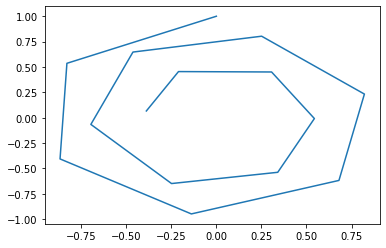

In [61]:
plt.plot(resultsy, resultsz)

In [35]:
def trotterstep_to_layers(step):
    circuits = []
    new_circ = QuantumCircuit(step.qubits)
    old_qubits = set()
    new_qubits = set()

    for gate in step:
        if gate.operation.num_qubits == 2:
            for q in gate.qubits:
                new_qubits.add(q)

        if new_qubits.intersection(old_qubits):
            old_qubits = new_qubits.copy()
            new_qubits = set()
            circuits.append(new_circ)
            new_circ = QuantumCircuit(step.qubits)

        if gate.operation.num_qubits == 1 and old_qubits:
            new_qubits = set()
            old_qubits = set()
            circuits.append(new_circ)
            new_circ = QuantumCircuit(step.qubits)

        old_qubits = old_qubits.union(new_qubits)
        new_circ.append(gate)
        new_qubits = set()

    circuits.append(new_circ)
            
    return circuits

In [62]:
circs = trotterstep_to_layers(step)

In [69]:
layer = circs[1]
layer.draw()

0: ──────────────■──
   ┌──────────┐┌─┴─┐
1: ┤ Rz(0.15) ├┤ X ├
   └──────────┘└───┘
2: ──────────────■──
   ┌──────────┐┌─┴─┐
3: ┤ Rz(0.15) ├┤ X ├
   └──────────┘└───┘

Running with PEC

In [67]:
class TrotterCircuit:
    def __init__(self, trotterLayers, noise_model, last_layer = None):
        #trotter layers is a list of quantum circuits decomposed as a number of single gate layers follwed by a two-qubit layer (both optional)
        #measurement_basis is the pauli expectation value to be measured
        #noise_model is a list of lists of tuples with paulis and model coefficients for sampling
        #the last_layer can be used if the trotter steps decompose in reverse order, if set it will trigger the subsequent layers to be flipped
        self.qubits = trotterLayers[0].qubits
        self.trotterLayers = trotterLayers
        self.noise_model = noise_model
        self.last_layer = last_layer
    

    def layer_with_PEC(self,layer, noise_model, last_twirl = None):
        qubits = [q.index for q in layer.qubits]
        circ = QuantumCircuit(layer.qubits)
        cliff = circ.copy()

        if last_twirl:
            circ.append(last_twirl, self.qubits)

        for gate in layer:
            match gate.operation.num_qubits:
                case 1:
                    circ.append(gate)
                case 2:
                    cliff.append(gate)

        pauli = Pauli("".join(choices("IXYZ", k=layer.num_qubits))) 
        mitigation, sign = self.sample(noise_model, layer.num_qubits)

        circ.append(pauli, self.qubits)
        circ.append(mitigation, self.qubits)

        for gate in layer:
            if gate.operation.num_qubits == 2:
                circ.append(gate)
        return circ, pauli, sign

    def sample(self, noise_model,n):
        operator = Pauli("I"*n)
        sgn = 0
        for term, prob in noise_model:
            if random() < prob:
                operator = operator.compose(term)
                sgn ^= 1
        return operator, sgn

    def trotterstep_with_PEC(self):
        circ = QuantumCircuit(self.qubits)
        pauli = None
        overall_sign = 0
        for layer,noise_model in zip(self.trotterLayers, self.noise_model):
            qc, pauli, sgn = self.layer_with_PEC(layer, noise_model, pauli)
            circ = circ.compose(qc)
            overall_sign ^= sgn
            circ.barrier()
        return circ

    def trotter_with_PEC(self,measurement_basis):
        pass

In [471]:
circ.draw()

┌───┐    ┌───┐          
0: ───┤ X ├────┤ I ├──────────
      ├───┤    ├───┤          
1: ───┤ X ├────┤ I ├───────■──
   ┌──┴───┴───┐├───┤┌───┐┌─┴─┐
2: ┤ Rz(0.15) ├┤ X ├┤ I ├┤ X ├
   └──┬───┬───┘├───┤└───┘└───┘
3: ───┤ X ├────┤ I ├──────────
      └───┘    └───┘

In [71]:
tl = TrotterCircuit(circs, [l]*4)

In [74]:
l = [(Pauli("XXII"), .1), (Pauli("IIXX"), .2)]
circ = tl.trotterstep_with_PEC()

/tmp/ipykernel_367109/2337152484.py:14: DeprecationWarning: Back-references to from Bit instances to their containing Registers have been deprecated. Instead, inspect Registers to find their contained Bits.
  qubits = [q.index for q in layer.qubits]


In [73]:
circ.draw()

┌───────┐┌──────────────┐┌──────────────┐      ░ ┌──────────────┐»
0: ┤ Rx(1) ├┤0             ├┤0             ├──■───░─┤0             ├»
   ├───────┤│              ││              │┌─┴─┐ ░ │              │»
1: ┤ Rx(1) ├┤1             ├┤1             ├┤ X ├─░─┤1             ├»
   ├───────┤│  Pauli(YXYZ) ││  Pauli(IIII) │└───┘ ░ │  Pauli(YXYZ) │»
2: ┤ Rx(1) ├┤2             ├┤2             ├──■───░─┤2             ├»
   ├───────┤│              ││              │┌─┴─┐ ░ │              │»
3: ┤ Rx(1) ├┤3             ├┤3             ├┤ X ├─░─┤3             ├»
   └───────┘└──────────────┘└──────────────┘└───┘ ░ └──────────────┘»
«               ┌──────────────┐┌──────────────┐      ░ ┌──────────────┐»
«0: ────────────┤0             ├┤0             ├──■───░─┤0             ├»
«   ┌──────────┐│              ││              │┌─┴─┐ ░ │              │»
«1: ┤ Rz(0.15) ├┤1             ├┤1             ├┤ X ├─░─┤1             ├»
«   └──────────┘│  Pauli(XYZX) ││  Pauli(IIII) │└───┘ ░ │  Pauli(XYZX) │»
«2: ────────────┤2             ├┤2             ├──■───░─┤2             ├»
«   ┌──────────┐│              ││              │┌─┴─┐ ░ │              │»
«3: ┤ Rz(0.15) ├┤3             ├┤3             ├┤ X ├─░─┤3             ├»
«   └──────────┘└──────────────┘└──────────────┘└───┘ ░ └──────────────┘»
«   ┌──────────────┐┌──────────────┐      ░ ┌──────────────┐            »
«0: ┤0             ├┤0             ├──────░─┤0             ├────────────»
«   │              ││              │      ░ │              │            »
«1: ┤1             ├┤1             ├──■───░─┤1             ├────────────»
«   │  Pauli(IYIZ) ││  Pauli(IIII) │┌─┴─┐ ░ │  Pauli(IYIZ) │┌──────────┐»
«2: ┤2             ├┤2             ├┤ X ├─░─┤2             ├┤ Rz(0.15) ├»
«   │              ││              │└───┘ ░ │              │└──────────┘»
«3: ┤3             ├┤3             ├──────░─┤3             ├────────────»
«   └──────────────┘└──────────────┘      ░ └──────────────┘            »
«   ┌──────────────┐┌──────────────┐      ░ 
«0: ┤0             ├┤0             ├──────░─
«   │              ││              │      ░ 
«1: ┤1             ├┤1             ├──■───░─
«   │  Pauli(IZYI) ││  Pauli(IIXX) │┌─┴─┐ ░ 
«2: ┤2             ├┤2             ├┤ X ├─░─
«   │              ││              │└───┘ ░ 
«3: ┤3             ├┤3             ├──────░─
«   └──────────────┘└──────────────┘      ░